In [5]:
import numpy as np
import pandas as pd

import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers

### y값 cosine-similarity

In [6]:
with open("../input/tobigs/tag_embedding.pickle", 'rb') as f:
    tagdata = pickle.load(f).reset_index(drop=True)

with open("../input/tobigs/mel_embedding.pickle", 'rb') as f:
    meldata = pickle.load(f).reset_index(drop=True)

X1=tagdata['tag_embedding']
X2=meldata['mel_embedding']
#y=list(map(float,data['label']))

In [7]:
'''
with open("../input/tobigsmall/final_embedding_48.pickle", 'rb') as f:
    data = pickle.load(f).reset_index(drop=True)
    
X1=data['tag_embedding']
X2=data['mel_embedding']
'''

'\nwith open("../input/tobigsmall/final_embedding_48.pickle", \'rb\') as f:\n    data = pickle.load(f).reset_index(drop=True)\n    \nX1=data[\'tag_embedding\']\nX2=data[\'mel_embedding\']\n'

In [8]:
X3 = pd.read_csv("../input/tobigsmall/genre.csv",index_col = 0)


In [9]:
X4 = pd.read_csv("../input/tobigsmall/singer.csv",index_col = 0)

In [10]:
X4.max()

singer    120358
dtype: int64

In [11]:
data = {
    'First' : ['0'],
    'Second' : ['0'],
    'Simiarity' : [0]
}
X_cosine = pd.DataFrame(data)

In [12]:
def cos_sim(A, B):
  return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [13]:
# 랜덤한  n쌍 생성

import random
data = {
    'First' : [0],
    'Second' : [0]
}
pair = pd.DataFrame(data)


n = 100000

for i in tqdm(range(n)):
  a = random.randrange(0,n)
  b = random.randrange(0,n)
  data ={'First':a, 'Second':b}
  pair = pair.append(data,ignore_index=True)
    
pair = pair[1:]

#중복데이터 확인
pair[pair.duplicated(keep='last')]

100%|██████████| 100000/100000 [01:59<00:00, 833.66it/s]


,First,Second


In [14]:
list_sim = []

for i in tqdm(range(len(pair))):
    a = pair.iloc[i]['First']
    b = pair.iloc[i]['Second']
    ijcos = cos_sim(X1[a],X1[b])
    list_sim.append(ijcos)

#태그간 코사인 유사도
pair.loc[:,'Sim'] = list_sim

100%|██████████| 100000/100000 [00:18<00:00, 5286.99it/s]


In [15]:
# 넘파이 할당
X1_new = np.zeros((n,256))
X2_new = np.zeros((n,48,20))
X3_new = np.zeros((n,255))
X4_new = np.zeros(n)

for i in range(n):
    a = pair.iloc[i]['First'] 
    b = pair.iloc[i]['Second']
    X1_new[i] = X1[int(a)] #tag
    X2_new[i] = X2[int(b)] #mel
    X3_new[i] = X3.iloc[int(b),:] #mel과 함께 움직인다..
    X4_new[i] = X4.iloc[int(b)] #mel과 함께 움직인다..

    
y_new = pair['Sim']
#y_new = y_new.iloc[:-1]

In [16]:
X1 = X1_new
X2 = X2_new
X3 = X3_new
X4 = X4_new
y = y_new

In [17]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=1)
X1_train, X1_val, y_train, y_val = train_test_split(X1_train, y_train, test_size=0.25, random_state=1)


X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)
X2_train, X2_val, y_train, y_val = train_test_split(X2_train, y_train, test_size=0.25, random_state=1)


X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=1)
X3_train, X3_val, y_train, y_val = train_test_split(X3_train, y_train, test_size=0.25, random_state=1)

X4_train, X4_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=1)
X4_train, X4_val, y_train, y_val = train_test_split(X4_train, y_train, test_size=0.25, random_state=1)


In [18]:


initializer = keras.initializers.HeUniform(seed = 21)

dropout_rate = 0.2

mel_input = keras.Input(shape=(48,20,1), name="mel")


x2 = layers.Conv2D(32, 3, activation="relu")(mel_input)
x2 = layers.Conv2D(32, 3, activation="relu")(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.MaxPooling2D(2)(x2)

x2 = layers.Conv2D(64, 3, activation="relu", padding="same")(x2)
x2 = layers.Conv2D(64, 3, activation="relu", padding="same")(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.MaxPooling2D(2)(x2)
#2 = layers.add([x2, block_1_output])

x2 = layers.Conv2D(128, 3, activation="relu", padding="same")(x2)
x2 = layers.Conv2D(128, 3, activation="relu", padding="same")(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
#x2 = layers.MaxPooling2D(2)(x2)

#x2 = layers.Conv2D(256, 3, activation="relu", padding="same")(x2)
#x2 = layers.Conv2D(256, 3, activation="relu", padding="same")(x2)
#x2 = layers.BatchNormalization(trainable=True)(x2)
#x2 = layers.Dropout(dropout_rate)(x2)
#x2 = layers.GlobalMaxPooling2D()(x2)
#x2 = layers.MaxPooling1D()(x2)
#x2 = layers.Flatten()(x2)      레이어가 너무 많으면 오히려 별로임

x2 = layers.Reshape((-1,256))(x2)
x2 = layers.LSTM(64)(x2)


singer_input = keras.Input(shape=(1,),name='singer')
x4 = layers.Embedding(120358,4)(singer_input)
x4 = layers.Flatten()(x4)

gen_input = keras.Input(shape=(255,), name="gen")


x2 = tf.keras.layers.Concatenate()([gen_input, x2,x4])

'''
'''
x2 = layers.Dense(256, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(128, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(64, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(32, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dense(16,kernel_initializer=initializer)(x2) 


tag_input = keras.Input(shape=(256,), name="tag")

x1 = layers.Dense(256, activation="relu",kernel_initializer=initializer)(tag_input)
x1 = layers.BatchNormalization(trainable=True)(x1)
x1 = layers.Dropout(0.2)(x1)
x1 = layers.Dense(128, activation="relu",kernel_initializer=initializer)(x1)
x1 = layers.BatchNormalization(trainable=True)(x1)
x1 = layers.Dropout(0.2)(x1)
x1 = layers.Dense(64, activation="relu",kernel_initializer=initializer)(x1)
x1 = layers.BatchNormalization(trainable=True)(x1)
x1 = layers.Dropout(0.2)(x1)
x1 = layers.Dense(32, activation="relu",kernel_initializer=initializer)(x1)
x1 = layers.BatchNormalization(trainable=True)(x1)

x1 = layers.Dense(16,kernel_initializer=initializer)(x1)

import numpy as np
from numpy import dot
from numpy.linalg import norm


x3  = tf.keras.layers.Dot(axes=1,normalize=True)([x1, x2])



model = keras.Model(inputs=[tag_input,mel_input,gen_input,singer_input], outputs=x3, name="model")
model.summary()


2022-07-06 13:39:17.204907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:39:17.388923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:39:17.390022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:39:17.391802: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 48, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 18, 32)   320         mel[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 44, 16, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 44, 16, 32)   128         conv2d_1[0][0]                   
______________________________________________________________________________________________

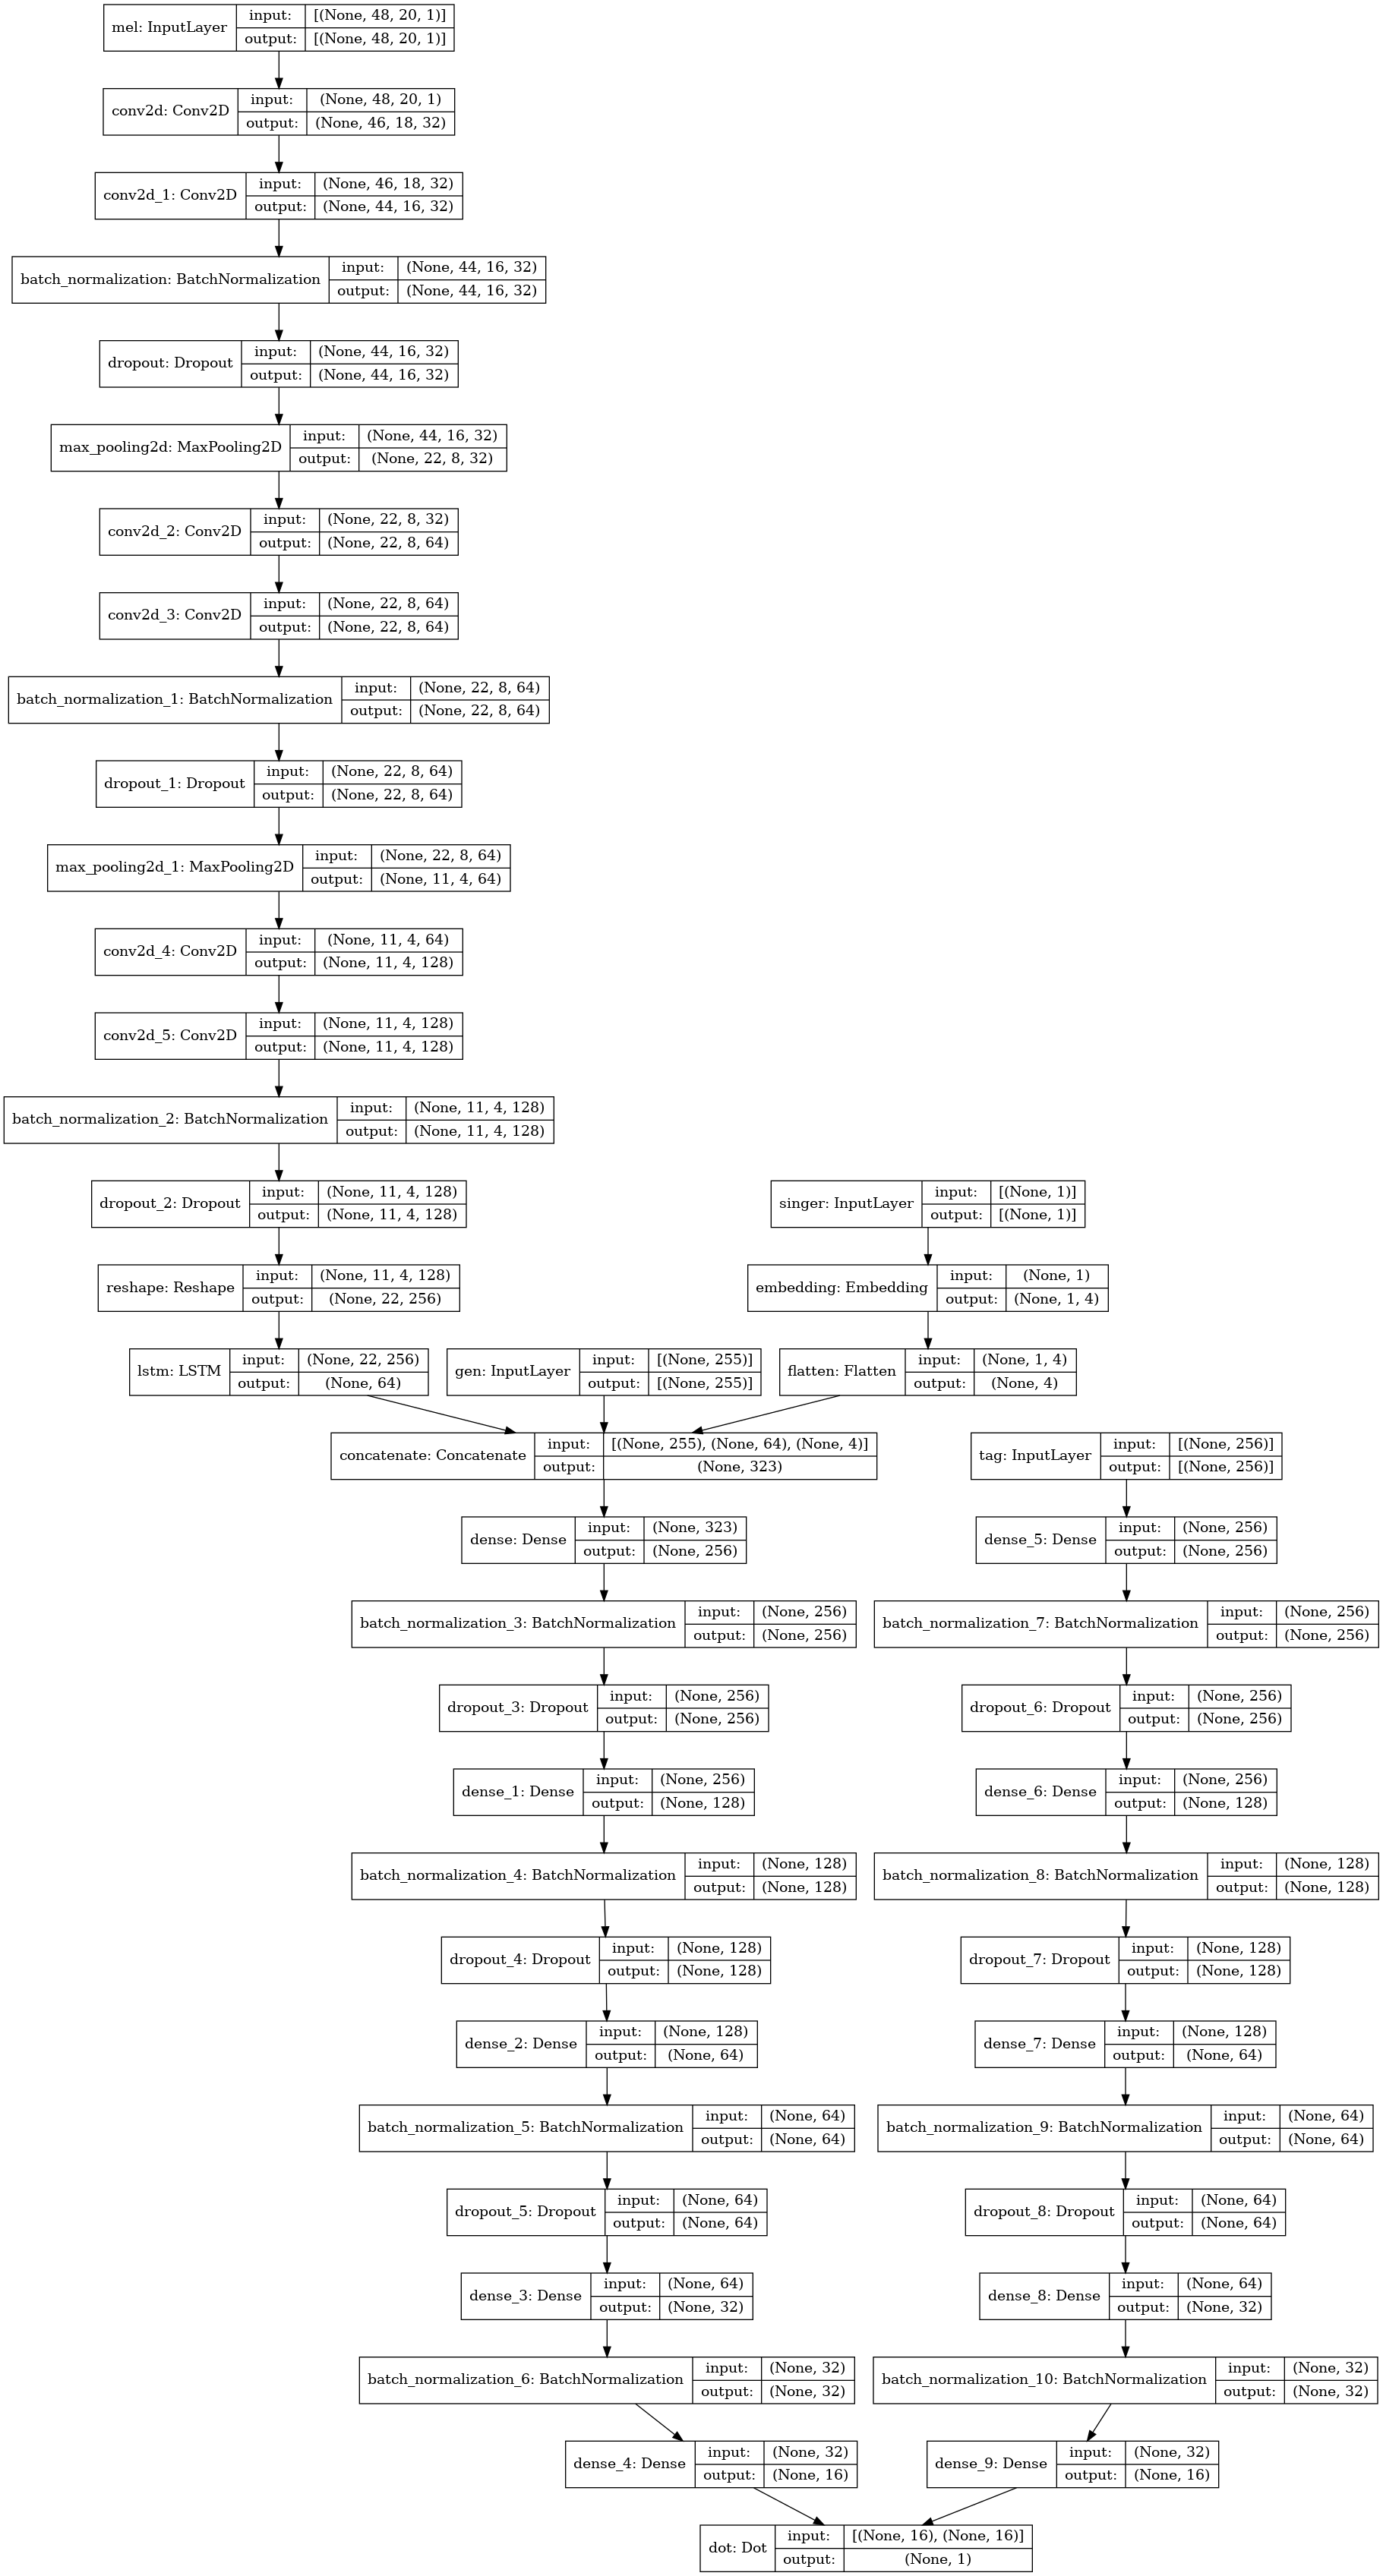

In [19]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [20]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stoping_callback = EarlyStopping(monitor='val_loss',patience=5,
                                      restore_best_weights=True)


from keras.utils import multi_gpu_utils


optimizer = keras.optimizers.Adam(lr=0.01, decay = 0.001)
with tf.device('/gpu:0'):
    model.compile(optimizer=optimizer,
                  loss= tf.keras.losses.MeanSquaredError()   , #tf.keras.losses.MeanSquaredError()   contrastive_loss
                  metrics=[tf.keras.metrics.MeanSquaredError()]) #


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
BATCH_SIZE = 256
EPOCHS = 20



result = model.fit([X1_train,X2_train,X3_train,X4_train] ,y_train, epochs=EPOCHS, 
                   validation_data = ([X1_val,X2_val,X3_val,X4_val] ,y_val), batch_size=BATCH_SIZE,
                  callbacks=[early_stoping_callback]) #


2022-07-06 13:39:22.901442: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 230400000 exceeds 10% of free system memory.
2022-07-06 13:39:23.322143: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 230400000 exceeds 10% of free system memory.
2022-07-06 13:39:23.599726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-06 13:39:29.849698: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


235/235 [==============================] - 18s 26ms/step - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 2/20
235/235 [==============================] - 5s 23ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 3/20
235/235 [==============================] - 5s 23ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 4/20
235/235 [==============================] - 5s 23ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 5/20
235/235 [==============================] - 5s 22ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 6/20
235/235 [==============================] - 5s 22ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 7/20
235/235 [============

In [22]:
model.save("my_singer_h5_model.h5")

In [23]:
y_pred = model.predict(x = (X1_val,X2_val,X3_val,X4_val))

In [24]:
y_pred.reshape(-1)

array([0.9206088 , 0.8810209 , 0.88906   , ..., 0.7703752 , 0.8665365 ,
       0.83042705], dtype=float32)

In [25]:
from sklearn.metrics import ndcg_score

ndcg_score(np.asarray([y_val]),np.array(y_pred).T)

0.9946635693622689

model.save("kaist.

In [26]:
from scipy import stats

tau, p_value = stats.kendalltau(y_val, y_pred)

print(tau, p_value)

0.4075997952577184 0.0


In [27]:
graph_data = pd.DataFrame({ "y_true" : np.asarray(y_val), "y_pred" : y_pred.reshape(-1)})

graph_data['diff'] = abs(graph_data['y_true'] - graph_data['y_pred'])

In [28]:
graph_data.sort_values(by=['y_pred']).reset_index(drop=True)

,y_true,y_pred,diff
0,0.440242,0.437242,0.003000
1,0.448546,0.461026,0.012480
2,0.455139,0.470450,0.015311
3,0.536094,0.474533,0.061561
4,0.873262,0.480385,0.392877
...,...,...,...
19995,0.739309,0.968892,0.229583
19996,0.985017,0.968973,0.016044
19997,0.898317,0.970443,0.072126
19998,0.976781,0.971632,0.005149


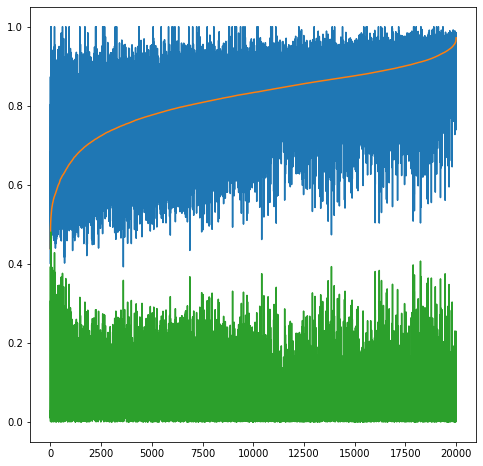

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(graph_data.sort_values(by=['y_pred']).reset_index(drop=True))
plt.show()